In [1]:
import torch
from torch import optim
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
num_workers = 0
batch_size = 20
valid_size = 0.2
transform = transforms.ToTensor()

In [3]:
# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

  0%|          | 16384/9912422 [00:00<01:30, 109229.03it/s]

9920512it [00:00, 25650795.52it/s]                           


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 315542.50it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7231654.46it/s]                            
8192it [00:00, 186811.82it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [5]:
num_train = len(train_data)
print("Number of training samples: ", num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
print("Shuffled indices ", indices[:10])
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

Number of training samples:  60000
Shuffled indices  [19702, 11058, 37076, 58590, 47764, 22661, 43564, 42686, 33203, 11431]


In [6]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

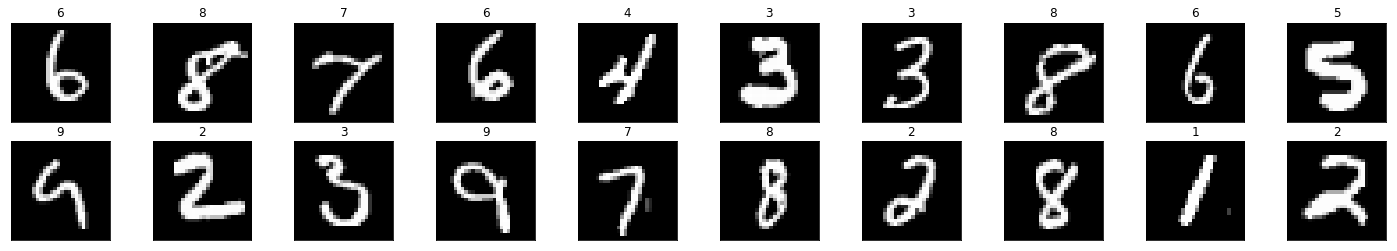

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

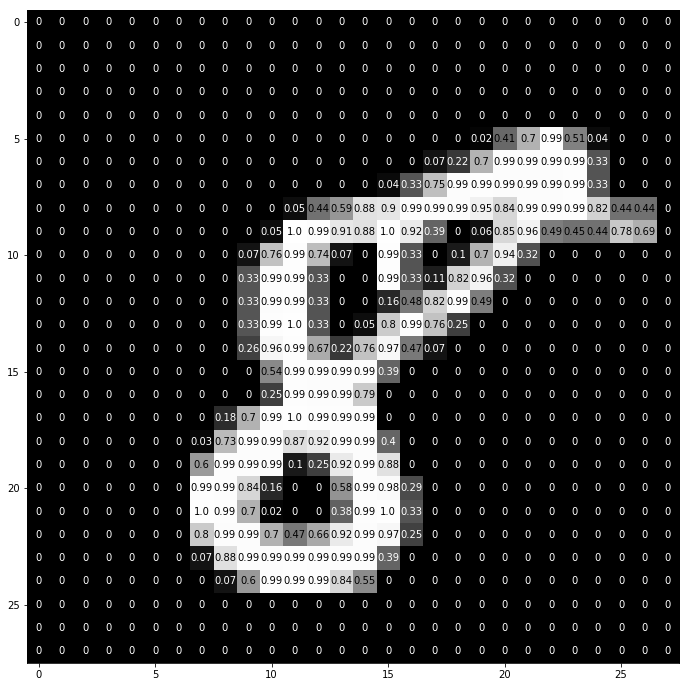

In [9]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        hidden_1 = 512
        hidden_2 = 128
        
        self.fc1 = nn.Linear(784, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        
        self.dropout = nn.Dropout(0.2)
            
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim = 1)
        
        return x
        

In [11]:
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [12]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [13]:
epochs = 15

valid_loss_min = np.Inf

model.train()

for e in range(epochs):
    
    train_loss = 0
    valid_loss = 0
    
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # PyTorch returns the average error for the mini batch, but we don't want that
        # hence we multiply it by the number of items to get the sum of all errors instead of avg
        train_loss += loss.item() * images.size(0)
        
    model.eval()
    for images, labels in valid_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = train_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.262104 	Validation Loss: 0.000022
Validation loss decreased (inf --> 0.000022).  Saving model ...
Epoch: 2 	Training Loss: 0.096890 	Validation Loss: 0.000008
Validation loss decreased (0.000022 --> 0.000008).  Saving model ...
Epoch: 3 	Training Loss: 0.067741 	Validation Loss: 0.000006
Validation loss decreased (0.000008 --> 0.000006).  Saving model ...
Epoch: 4 	Training Loss: 0.046970 	Validation Loss: 0.000004
Validation loss decreased (0.000006 --> 0.000004).  Saving model ...
Epoch: 5 	Training Loss: 0.037926 	Validation Loss: 0.000003
Validation loss decreased (0.000004 --> 0.000003).  Saving model ...
Epoch: 6 	Training Loss: 0.030752 	Validation Loss: 0.000003
Validation loss decreased (0.000003 --> 0.000003).  Saving model ...
Epoch: 7 	Training Loss: 0.026092 	Validation Loss: 0.000002
Validation loss decreased (0.000003 --> 0.000002).  Saving model ...
Epoch: 8 	Training Loss: 0.023514 	Validation Loss: 0.000002
Validation loss decreased (0.00000

In [14]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.137883

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 97% (1007/1032)
Test Accuracy of     3: 94% (958/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 98% (883/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 97% (1001/1028)
Test Accuracy of     8: 96% (944/974)
Test Accuracy of     9: 97% (988/1009)

Test Accuracy (Overall): 97% (9774/10000)
